# Stacking

Julian Domingo - jad5348

In [2]:
# Data analysis 
import pandas as pd
import numpy as np

# Modeling stuff
import xgboost as xgb
from xgboost import XGBClassifier
from mlens.ensemble import SuperLearner
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier,
                              ExtraTreesClassifier,
                              BaggingClassifier)
from sklearn.model_selection import GridSearchCV, cross_val_score

# Computation / numerical
from scipy.stats import uniform, randint, hmean
from sklearn.metrics import roc_auc_score
from mlens.preprocessing import Subset
from mlens.metrics import make_scorer
from mlens.model_selection import Evaluator
import matplotlib.pyplot as plt

# For reproducibility
seed = 42
np.random.seed(seed)

# Constants
n_splits = 5

[MLENS] backend: threading


In [3]:
test_ids = pd.read_csv("./data/raw/test.csv")[["id"]]
y_train = pd.read_csv("./data/raw/train.csv")["Y"].ravel()

#### Helper Functions

In [4]:
def save_preds(preds, preds_filename):
    submission = pd.DataFrame({"id": test_ids.id, "Y": preds})
    submission.to_csv("./submissions/stacking_{}.csv".format(preds_filename), index=False, columns=["id", "Y"])
    

def get_cross_val_score(model, x_train, y_train, n_folds, run_parallel=True):
    if run_parallel:
        cv = cross_val_score(model, x_train, y_train, cv = n_folds, scoring = "roc_auc", n_jobs = -1)
    else:
        cv = cross_val_score(model, x_train, y_train, cv = n_folds, scoring = "roc_auc")

    print("Cross validation score: {} +/- {}\nRaw scores: {}".format(str(np.mean(cv)), str(np.std(cv)), str(cv)))
    return cv

#### Stacking Class

Stacking works well for small to medium-sized data sets.

In [5]:
class Stacker(object):
    def __init__(self, base_learners, meta_learners, y_train, test_ids):
        self.base_learners = base_learners
        self.meta_learners = meta_learners
        self.y_train = y_train
        self.test_ids = test_ids
    
    
    def get_indiv_meta_preds(self, meta):
        """ Retrieves the predictions of the model 'meta'. """
        if self.meta_features_train is None or self.meta_features_test is None:
            raise ValueError("Invoke 'get_meta_features' before predicting.")
            
        meta.fit(self.meta_features_train, self.y_train)
        meta_preds = meta.predict_proba(self.meta_features_test)[:,1]
        return meta_preds
        
        
    def get_meta_features(self, mlens=False):
        """ Retrieves all meta features for the train & test data from the base learners specified. """
        self.meta_features_train = np.zeros((len(self.y_train), len(self.base_learners)))
        self.meta_features_test = np.zeros((len(self.test_ids), len(self.base_learners)))
        
        for i, base in enumerate(self.base_learners):
            print ("Gathering meta feature from '{}'...".format(base))
            
            if mlens:
                self.meta_features_train[:, i] = pd.read_csv("./meta_features/mlens/train/train_{}.csv".format(base), \
                                                             index_col=0).as_matrix().ravel()
                self.meta_features_test[:, i] = pd.read_csv("./meta_features/mlens/test/test_{}.csv".format(base), \
                                                             index_col=0).as_matrix().ravel()
            else:
                self.meta_features_train[:, i] = pd.read_csv("./meta_features/train/train_{}.csv".format(base), \
                                                             index_col=0).as_matrix().ravel()
                self.meta_features_test[:, i] = pd.read_csv("./meta_features/test/test_{}.csv".format(base), \
                                                            index_col=0).as_matrix().ravel()
            
        return self.meta_features_train.copy(), self.meta_features_test.copy()
    
    
    def fit_meta_learners_and_predict(self):
        """ Generates predictions using all meta features generated from the base learners for each meta learner. """
        if self.meta_features_train is None or self.meta_features_test is None:
            raise ValueError("get_meta_features() should be called before generate_out_of_folds_preds.")
        
        self.meta_learner_preds = np.zeros((len(self.test_ids), len(self.meta_learners)))
        
        for i, meta in enumerate(self.meta_learners):
            meta.fit(self.meta_features_train, self.y_train)
            self.meta_learner_preds[:, i] =  meta.predict_proba(self.meta_features_test)[:,1]
            
    
    def get_df_meta_learner_preds(self):
        if self.meta_learner_preds is None:
            raise ValueError("No predictions were found. Invoke 'fit_meta_learners_and_predict' first.")
        
        if self.base_learners is None:
            raise ValueError("No base learners were specified. Construct an instance with base learners.")
        
        return pd.DataFrame(self.meta_learner_preds, columns=self.base_learners)
    
    
    def get_final_preds(self, mean="average"):
        if mean == "average":
            return np.mean(self.meta_learner_preds, axis=1)
        elif mean == "harmonic":
            return hmean(self.meta_learner_preds, axis=1)

## Meta Learner(s) Parameter Tuning & Predictions

### Ensemble 1
**Base Learners: **
    * RF Raw
    * RF Log
    * RF Poly
    * XGB Raw
    * XGB Base
    * XGB Poly
    * LR Log
    * Ada Base
   
**Meta Learners: **
    * RF

In [31]:
base_learners_v1 = [
    "random_forest_raw",
    "random_forest_log",
    "random_forest_poly",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "logistic_regression_log",
    "adaboost_base"
]

rf_meta_v1 = RandomForestClassifier(n_jobs=-1)

meta_learners_v1 = [rf_meta_v1]

In [32]:
stacker_v1 = Stacker(base_learners_v1, meta_learners_v1, y_train, test_ids)
meta_features_train_v1, meta_features_test_v1 = stacker_v1.get_meta_features()

Gathering meta feature from 'random_forest_raw'...
Gathering meta feature from 'random_forest_log'...
Gathering meta feature from 'random_forest_poly'...
Gathering meta feature from 'xgboost_raw'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_poly'...
Gathering meta feature from 'logistic_regression_log'...
Gathering meta feature from 'adaboost_base'...


In [11]:
# Warning: this block takes a long time to execute.
rf_meta_v1_param_grid = {
    "max_features": range(5, 7 + 1),
    "max_depth": range(5, 10 + 1),
    "n_estimators": range(300, 1000 + 1, 100) 
}

gs_rf_v1 = GridSearchCV(estimator=rf_meta_v1, param_grid=rf_meta_v1_param_grid, cv=n_splits, scoring="roc_auc", n_jobs=-1)
gs_rf_v1.fit(meta_features_train_v1, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [5, 6, 7], 'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [10]:
print gs_rf_v1.best_params_
print gs_rf_v1.best_score_

{'max_features': 6, 'n_estimators': 300, 'max_depth': 6}
0.772539082175


In [33]:
print get_cross_val_score(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=6, max_features=6), meta_features_train_v1, y_train, n_folds=5)

Cross validation score: 0.771359868469 +/- 0.00723717612684
Raw scores: [ 0.76715711  0.77956341  0.75947714  0.77377431  0.77682737]
[ 0.76715711  0.77956341  0.75947714  0.77377431  0.77682737]


In [19]:
# Get predictions w/ tuned params
meta_preds_v1 = stacker_v1.get_indiv_meta_preds(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_features=6, max_depth=6))
print meta_preds_v1

[ 0.97136003  0.67447269  0.94252603 ...,  0.88289829  0.98178302
  0.96819782]


In [25]:
# Get predictions w/o tuned params
meta_preds_v1_untuned = stacker_v1.get_indiv_meta_preds(RandomForestClassifier(n_jobs=-1))
print meta_preds_v1_untuned

[ 1.   0.7  0.9 ...,  1.   1.   1. ]


As seen by the predictions without tuned parameters, tuning of the meta model makes a tremendous difference on the prediction set obtained.

### Ensemble 2
**Base Learners: **
    * RF Raw
    * RF Log
    * RF Poly
    * XGB Raw
    * XGB Base
    * XGB Poly
    * LR Log
    * Ada Base
    * KNN_{2, 4, 8, 16, 32, 64, 128, 256, 512, 1024}
   
**Meta Learners: **
    * RF

In [24]:
base_learners_v2 = [
    "random_forest_raw",
    "random_forest_log",
    "random_forest_poly",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "logistic_regression_log",
    "adaboost_base",
    "knn_2",
    "knn_4",
    "knn_8",
    "knn_16",
    "knn_32",
    "knn_64",
    "knn_128",
    "knn_256",
    "knn_512",
    "knn_1024"
]

rf_meta_v2 = RandomForestClassifier(n_jobs=-1)
meta_learners_v2 = [rf_meta_v2]

stacker_v2 = Stacker(base_learners_v2, meta_learners_v2, y_train, test_ids)
meta_features_train_v2, meta_features_test_v2 = stacker_v2.get_meta_features()

Gathering meta feature from 'random_forest_raw'...
Gathering meta feature from 'random_forest_log'...
Gathering meta feature from 'random_forest_poly'...
Gathering meta feature from 'xgboost_raw'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_poly'...
Gathering meta feature from 'logistic_regression_log'...
Gathering meta feature from 'adaboost_base'...
Gathering meta feature from 'knn_2'...
Gathering meta feature from 'knn_4'...
Gathering meta feature from 'knn_8'...
Gathering meta feature from 'knn_16'...
Gathering meta feature from 'knn_32'...
Gathering meta feature from 'knn_64'...
Gathering meta feature from 'knn_128'...
Gathering meta feature from 'knn_256'...
Gathering meta feature from 'knn_512'...
Gathering meta feature from 'knn_1024'...


In [29]:
# Warning: this block takes a long time to execute.
rf_meta_v2_param_grid = {
    "max_features": range(5, 7 + 1),
    "max_depth": range(5, 10 + 1),
    "n_estimators": range(300, 1000 + 1, 100) 
}

gs_rf_v2 = GridSearchCV(estimator=rf_meta_v2, param_grid=rf_meta_v2_param_grid, cv=n_splits, scoring="roc_auc", n_jobs=-1)
gs_rf_v2.fit(meta_features_train_v2, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_features': [5, 6, 7], 'n_estimators': [300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [30]:
print gs_rf_v2.best_params_
print gs_rf_v2.best_score_

{'max_features': 5, 'n_estimators': 300, 'max_depth': 9}
0.773074767924


In [30]:
print get_cross_val_score(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=9, max_features=5), meta_features_train_v2, y_train, n_folds=5)

Cross validation score: 0.769897637451 +/- 0.00448583181217
Raw scores: [ 0.76837689  0.77614972  0.77087385  0.76246286  0.77162487]
[ 0.76837689  0.77614972  0.77087385  0.76246286  0.77162487]


In [31]:
# Get predictions w/ tuned params
meta_preds_v2_tuned = stacker_v2.get_indiv_meta_preds(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=9, max_features=5))
print meta_preds_v2_tuned

[ 0.97460188  0.66699757  0.95640802 ...,  0.91079086  0.98644606
  0.97122791]


In [33]:
save_preds(meta_preds_v2_tuned, "_".join(base_learners_v2))

### Ensemble 3
**Base Learners: **
    * RF Raw
    * RF Log
    * RF Poly
    * XGB Raw
    * XGB Base
    * XGB Reduced
    * XGB Poly
    * LR Log
    * Ada Base
    * Bagged XGB (50 runs)
    * Extra Trees Base
    
**Meta Learners: **
    * RF
    * XGB
    
**Final Predictions**: harmonic mean of meta learner predictions

In [33]:
base_learners_v3 = [
    "random_forest_raw",
    "random_forest_log",
    "random_forest_poly",
    "xgboost_reduced",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "xgboost_bag",
    "logistic_regression_log",
    "adaboost_base",
    "extra_trees_base"
]

rf_meta_v3 = RandomForestClassifier(n_jobs=-1, max_features=2, n_estimators=300, max_depth=8, random_state=seed)
meta_learners_v3 = [rf_meta_v3]

stacker_v3 = Stacker(base_learners_v3, meta_learners_v3, y_train, test_ids)
meta_features_train_v3, meta_features_test_v3 = stacker_v3.get_meta_features()

Gathering meta feature from 'random_forest_raw'...
Gathering meta feature from 'random_forest_log'...
Gathering meta feature from 'random_forest_poly'...
Gathering meta feature from 'xgboost_reduced'...
Gathering meta feature from 'xgboost_raw'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_poly'...
Gathering meta feature from 'xgboost_bag'...
Gathering meta feature from 'logistic_regression_log'...
Gathering meta feature from 'adaboost_base'...
Gathering meta feature from 'extra_trees_base'...


#### Random Forest Tuning

In [342]:
# Warning: this block takes a long time to execute.
rf_v3_param_grid = {
    "max_features": range(3, 5 + 1),
    "max_depth": range(8, 10 + 1),
    "n_estimators": range(250, 350 + 1, 10) 
}

gs_rf_v3 = GridSearchCV(estimator=rf_meta_v3, param_grid=rf_v3_param_grid, cv=n_splits, scoring="roc_auc", n_jobs=-1, verbose=1)
gs_rf_v3.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


KeyboardInterrupt: 

In [ ]:
print gs_rf_v3.best_params_
print gs_rf_v3.best_score_

{'max_features': 2, 'n_estimators': 300, 'max_depth': 8}
0.776661015238


In [325]:
# After first iteration
print gs_rf_v3.best_params_
print gs_rf_v3.best_score_

{'max_features': 5, 'n_estimators': 310, 'max_depth': 9}
0.7771661899370343


In [ ]:
# Adding xgbreduced
print gs_rf_v3.best_params_
print gs_rf_v3.best_score_

In [343]:
print get_cross_val_score(RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=8, max_features=2, random_state=seed),
                          meta_features_train_v3,
                          y_train,
                          n_folds=5)

Cross validation score: 0.7758377713611871 +/- 0.00887867046923868
Raw scores: [0.77596569 0.78868348 0.76137561 0.77351094 0.77965313]
[0.77596569 0.78868348 0.76137561 0.77351094 0.77965313]


In [ ]:

print get_cross_val_score(RandomForestClassifier(n_jobs=-1, n_estimators=310, max_depth=9, max_features=5, random_state=seed),
                          meta_features_train_v3,
                          y_train,
                          n_folds=5)

In [81]:
meta_preds_v3_tuned = stacker_v3.get_indiv_meta_preds(RandomForestClassifier(n_jobs=-1,
                                                                             n_estimators=300,
                                                                             max_depth=8,
                                                                             max_features=2, random_state=seed))
print meta_preds_v3_tuned

[0.97333875 0.64369521 0.93752947 ... 0.90418185 0.982669   0.96400992]


In [82]:
save_preds(meta_preds_v3_tuned, "rf_only_meta_{}".format("_".join(base_learners_v3)))

#### XGB Meta Learner Parameter Tuning

Note that the "final_params" dictionary is iteratively updated as more parameters are tuned. The initial values are the same listed in the lauyer_1_models jupyter notebook.

In [71]:
# TODO: Change the "after first iteration" block when adding new metafeatures
final_xgb_v3_params = {
    "learning_rate": 0.1,
    "n_estimators": 39,
    "max_depth": 4,
    "min_child_weight": 0,
    "gamma": 0.175,
    "subsample": 0.65,
    "colsample_bytree": 0.5,
    "objective": 'binary:logistic', # Used for classifier XGB
    "scale_pos_weight": 1,
    "seed": seed
}  

In [52]:
xgb_meta_v3 = XGBClassifier(**final_xgb_v3_params)

# Warning: this block takes a long time to execute.
xgb_v3_n_est = {
    "n_estimators": range(30, 70)
}

gs_xgb_v3_n_est = GridSearchCV(estimator=xgb_meta_v3, param_grid=xgb_v3_n_est, cv=n_splits, scoring="roc_auc", n_jobs=-1, verbose=1)
gs_xgb_v3_n_est.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   13.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.185, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=0, missing=None,
       n_estimators=39, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.65),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [36]:
# With no KNNs
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 56}
0.7743626942129123


In [228]:
# After first iteration 
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 39}
0.7790001418640146


In [272]:
# Corrected from first iteration
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 42}
0.7783016226867695


In [294]:
# After second iteration. Converged to final value.
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 42}
0.778939645637447


In [53]:
# After second iteration
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 39}
0.778119416007


In [33]:
xgb_base_params = {
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "max_depth": 5,
    "min_child_weight": 1,
    "gamma": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": 'binary:logistic', # Used for classifier XGB
    "scale_pos_weight": 1,
    "seed": seed
}

In [55]:
xgb_v3_md_mcw = {
    "max_depth": range(1, 6),
    "min_child_weight": range(0, 6 + 1)
}

gs_xgb_v3_md_mcw = GridSearchCV(estimator=XGBClassifier(**final_xgb_v3_params), 
                                                       param_grid=xgb_v3_md_mcw, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_md_mcw.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:    8.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.185, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=0, missing=None,
       n_estimators=39, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.65),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5], 'min_child_weight': [0, 1, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [44]:
# Run 1
print gs_xgb_v3_md_mcw.best_params_
print gs_xgb_v3_md_mcw.best_score_

{'max_depth': 3, 'min_child_weight': 0}
0.77683418973155


In [275]:
# After first iteration
print gs_xgb_v3_md_mcw.best_params_
print gs_xgb_v3_md_mcw.best_score_

{'max_depth': 3, 'min_child_weight': 2}
0.778939645637447


In [57]:
# After second iteration
print gs_xgb_v3_md_mcw.best_params_
print gs_xgb_v3_md_mcw.best_score_

{'max_depth': 4, 'min_child_weight': 0}
0.778119416007


In [64]:
xgb_v3_gamma = {
#     "gamma": [0.185, 0.186, 0.187, 0.188, 0.189, 0.19, 0.191, 0.192, 0.193, 0.194, 0.195]
    "gamma": [0.17, 0.175, 0.18, 0.185, 0.19]
}

gs_xgb_v3_gamma = GridSearchCV(estimator=XGBClassifier(**final_xgb_v3_params), 
                                                       param_grid=xgb_v3_gamma, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_gamma.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.175, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=0, missing=None,
       n_estimators=39, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.65),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': [0.17, 0.175, 0.18, 0.185, 0.19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [56]:
# Run 1
print gs_xgb_v3_gamma.best_params_
print gs_xgb_v3_gamma.best_score_

{'gamma': 0.2}
0.7768581661860074


In [58]:
# Run 2
print gs_xgb_v3_gamma.best_params_
print gs_xgb_v3_gamma.best_score_

{'gamma': 0.19}
0.7768581661860074


In [290]:
# After first iteration
print gs_xgb_v3_gamma.best_params_
print gs_xgb_v3_gamma.best_score_

{'gamma': 0.185}
0.778939645637447


In [65]:
# After second iteration
print gs_xgb_v3_gamma.best_params_
print gs_xgb_v3_gamma.best_score_

{'gamma': 0.175}
0.778119416007


In [66]:
xgb_v3_ss_cb = {
#     "subsample": [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8],
#     "colsample_bytree": [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
    "subsample": [0.645, 0.65, 0.655],
    "colsample_bytree": [0.5, 0.55, 0.6]
}

gs_xgb_v3_ss_cb = GridSearchCV(estimator=XGBClassifier(**final_xgb_v3_params), 
                                                       param_grid=xgb_v3_ss_cb, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_ss_cb.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    3.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.175, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=0, missing=None,
       n_estimators=39, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.65),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.645, 0.65, 0.655], 'colsample_bytree': [0.5, 0.55, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [64]:
# Run 1
print gs_xgb_v3_ss_cb.best_params_
print gs_xgb_v3_ss_cb.best_score_

{'subsample': 0.65, 'colsample_bytree': 0.5}
0.7779686180633612


In [288]:
# After first iteration
print gs_xgb_v3_ss_cb.best_params_
print gs_xgb_v3_ss_cb.best_score_

{'subsample': 0.65, 'colsample_bytree': 0.5}
0.778939645637447


In [67]:
# After second iteration
print gs_xgb_v3_ss_cb.best_params_
print gs_xgb_v3_ss_cb.best_score_

{'subsample': 0.65, 'colsample_bytree': 0.5}
0.778119416007


In [68]:
# Make fresh Stacker instance
base_learners_v3_final = [
    "random_forest_raw",
    "random_forest_log",
    "random_forest_poly",
    "xgboost_reduced",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "xgboost_bag",
    "logistic_regression_log",
    "adaboost_base",
    "extra_trees_base"
]

rf_final_v3 = RandomForestClassifier(n_estimators=300, max_depth=8, max_features=2, random_state=seed)
xgb_final_v3 = XGBClassifier(**final_xgb_v3_params)

meta_learners_v3_final = [rf_final_v3, xgb_final_v3]

stacker_v3_final = Stacker(base_learners_v3_final, meta_learners_v3_final, y_train, test_ids)
train_final_v3, test_final_v3 = stacker_v3_final.get_meta_features()
stacker_v3_final.fit_meta_learners_and_predict()
stacker_v3_final_preds = stacker_v3_final.get_final_preds(mean="harmonic")

Gathering meta feature from 'random_forest_raw'...
Gathering meta feature from 'random_forest_log'...
Gathering meta feature from 'random_forest_poly'...
Gathering meta feature from 'xgboost_reduced'...
Gathering meta feature from 'xgboost_raw'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_poly'...
Gathering meta feature from 'xgboost_bag'...
Gathering meta feature from 'logistic_regression_log'...
Gathering meta feature from 'adaboost_base'...
Gathering meta feature from 'extra_trees_base'...


In [69]:
print stacker_v3_final_preds
save_preds(stacker_v3_final_preds, "{}_v2".format("_".join(base_learners_v3_final)))

[ 0.96800797  0.67794841  0.93948099 ...,  0.9077512   0.97617163
  0.95550081]


#### Ensemble 3b (added reduced xgb / svc with base data)

**Base Learners: **
    * RF Raw
    * RF Log
    * RF Poly
    * XGB Reduced
    * XGB Raw
    * XGB Base
    * XGB Poly
    * LR Log
    * Ada Base
    * Bagged XGB (50 runs)
    * Extra Trees Base
    * SVC Base
    
**Meta Learners: **
    * RF
    * XGB
    
**Final Predictions**: harmonic mean of meta learner predictions

In [26]:
base_learners_v3 = [
    "random_forest_raw",
    "random_forest_log",
    "random_forest_poly",
    "xgboost_reduced",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "xgboost_bag",
    "logistic_regression_log",
    "adaboost_base",
    "extra_trees_base",
    "svc_base"
]

rf_meta_v3 = RandomForestClassifier(n_jobs=-1, max_features=2, n_estimators=300, max_depth=8, random_state=seed)
meta_learners_v3 = [rf_meta_v3]

stacker_v3 = Stacker(base_learners_v3, meta_learners_v3, y_train, test_ids)
meta_features_train_v3, meta_features_test_v3 = stacker_v3.get_meta_features()

Gathering meta feature from 'random_forest_raw'...
Gathering meta feature from 'random_forest_log'...
Gathering meta feature from 'random_forest_poly'...
Gathering meta feature from 'xgboost_reduced'...
Gathering meta feature from 'xgboost_raw'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_poly'...
Gathering meta feature from 'xgboost_bag'...
Gathering meta feature from 'logistic_regression_log'...
Gathering meta feature from 'adaboost_base'...
Gathering meta feature from 'extra_trees_base'...
Gathering meta feature from 'svc_base'...


In [23]:
xgb_v3_b = {
    "learning_rate": 0.1,
    "n_estimators": 42,
    "max_depth": 3,
    "min_child_weight": 2,
    "gamma": 0.19,
    "subsample": 0.65,
    "colsample_bytree": 0.5,
    "objective": 'binary:logistic', # Used for classifier XGB
    "scale_pos_weight": 1,
    "seed": seed
}  

In [27]:
xgb_meta_v3 = XGBClassifier(**xgb_v3_b)

# Warning: this block takes a long time to execute.
xgb_v3_n_est = {
    "n_estimators": range(30, 70)
}

gs_xgb_v3_n_est = GridSearchCV(estimator=xgb_meta_v3, param_grid=xgb_v3_n_est, cv=n_splits, scoring="roc_auc", n_jobs=-1, verbose=1)
gs_xgb_v3_n_est.fit(meta_features_train_v3, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0.19, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=2, missing=None,
       n_estimators=42, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.65),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [334]:
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 53}
0.7752741875519101


In [28]:
# With all 3b models
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 30}
0.775114727204


In [25]:
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 45}
0.775986645495


In [ ]:
xgb_v3_md_mcw = {
    "max_depth": range(1, 6),
    "min_child_weight": range(0, 6 + 1)
}

gs_xgb_v3_md_mcw = GridSearchCV(estimator=XGBClassifier(**xgb_v3_b), 
                                                       param_grid=xgb_v3_md_mcw, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_md_mcw.fit(meta_features_train_v3, y_train)

### ML-ensemble Predictions

#### v1

In [77]:
rf_meta_mlens_v1 = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=6)

mlens_base_learners = [
    RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1),
    LogisticRegression(C=100, tol=1e-05, solver="liblinear"),
    AdaBoostClassifier(n_estimators=395, learning_rate=1.55),
    XGBClassifier(learning_rate=0.1,
                    n_estimators=345,
                    max_depth=8,
                    min_child_weight=2,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.5,
                    objective="binary:logistic",
                    n_jobs=-1,
                    scale_pos_weight=1,
                    seed=seed)
]

ensemble_v1 = SuperLearner(random_state=seed, scorer=roc_auc_score)
ensemble_v1.add(mlens_base_learners, proba=True)
ensemble_v1.add_meta(rf_meta_mlens_v1, proba=True)
mlens_v1_preds = ensemble_v1.fit(meta_features_train_v1, y_train).predict_proba(meta_features_test_v1)[:,1]

In [78]:
print mlens_v1_preds
save_preds(mlens_v1_preds, "mlens_v1")

[ 0.9640277   0.70394427  0.95102447 ...,  0.89943802  0.98440754
  0.95957553]


#### v2

In [34]:
rf_meta_mlens_v2 = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=9, max_features=5)

mlens_base_learners = [
    RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1),
    LogisticRegression(C=100, tol=1e-05, solver="liblinear"),
    ExtraTreesClassifier(max_depth=12, n_estimators=250, n_jobs=-1, criterion="entropy"),
    AdaBoostClassifier(n_estimators=395, learning_rate=1.55),
    XGBClassifier(learning_rate=0.1,
                    n_estimators=345,
                    max_depth=8,
                    min_child_weight=2,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.5,
                    objective="binary:logistic",
                    n_jobs=-1,
                    scale_pos_weight=1,
                    seed=seed),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=2),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=4),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=8),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=16),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=32),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=64),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=128),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=256),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=512),
    KNeighborsClassifier(n_jobs=-1, n_neighbors=1024)
]

ensemble_v2 = SuperLearner(random_state=seed, scorer=roc_auc_score)
ensemble_v2.add(mlens_base_learners, proba=True)
ensemble_v2.add_meta(rf_meta_mlens_v2, proba=True)
mlens_v2_preds = ensemble_v2.fit(meta_features_train_v2, y_train).predict_proba(meta_features_test_v2)[:,1]

In [35]:
print mlens_v2_preds
save_preds(mlens_v2_preds, "mlens_v2")

[ 0.97149235  0.76364833  0.96501911 ...,  0.92276353  0.98632556
  0.96678698]


After looking at the LB scores, it seems adding KNeighborsClassifier models don't improve the stacking ensemble.

#### v3

In [70]:
#     "random_forest_raw",
#     "random_forest_log",
#     "random_forest_poly",
#     "xgboost_reduced",
#     "xgboost_raw",
#     "xgboost_base",
#     "xgboost_poly",
#     "xgboost_bag",
#     "logistic_regression_log",
#     "adaboost_base",
#     "extra_trees_base"

# Base learners
rfc = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1)
lr = LogisticRegression(C=100, tol=1e-05, solver="liblinear")
et = ExtraTreesClassifier(max_depth=12, n_estimators=250, n_jobs=-1, criterion="entropy")
ada = AdaBoostClassifier(n_estimators=395, learning_rate=1.55)
xgb_base = XGBClassifier(learning_rate=0.1,
                    n_estimators=311,
                    max_depth=8,
                    min_child_weight=2,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.5,
                    objective="binary:logistic",
                    n_jobs=-1,
                    seed=seed)
xgb_reduced = XGBClassifier(learning_rate=0.1,
                    n_estimators=223,
                    max_depth=7,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.75,
                    objective="binary:logistic",
                    n_jobs=-1,
                    seed=seed)
xgb_raw = XGBClassifier(learning_rate=0.05,
                    n_estimators=308,
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.75,
                    colsample_bytree=0.35,
                    objective="binary:logistic",
                    n_jobs=-1,
                    seed=seed)
xgb_bag = BaggingClassifier(base_estimator=xgb_base,
                            n_estimators=40, 
                            max_samples=0.8, 
                            max_features=0.75, 
                            bootstrap_features=True)

In [ ]:
rf_meta_mlens_v3 = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=8, max_features=2)
xgb_meta_mlens_v3 = XGBClassifier(**final_xgb_v3_params)

# TODO: Tune poly xgb
mlens_base_learners_v3 = [rfc, lr, et, ada, xgb_raw, xgb_base, xgb_reduced, xgb_bag]

ensemble_v3 = SuperLearner(random_state=seed, scorer=roc_auc_score)
ensemble_v3.add(mlens_base_learners_v3, proba=True)
# ensemble_v3.add_meta(rf_meta_mlens_v3, proba=True)
ensemble_v3.add_meta(xgb_meta_mlens_v3, proba=True)
mlens_v3_preds = ensemble_v3.fit(meta_features_train_v3, y_train).predict_proba(meta_features_test_v3)[:,1]

/Users/julian/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing backed parallel loops cannot be nested below threads, setting n_jobs=1
  **self._backend_args)


In [23]:
print mlens_v3_preds
save_preds(mlens_v3_preds, "mlens_v3_xgb_meta_only")

[ 0.98159868  0.6663233   0.94211096 ...,  0.92641664  0.98821068
  0.95964485]


In [328]:
print mlens_v3_preds
save_preds(mlens_v3_preds, "mlens_v3_xgb_meta_only_2")

[0.9718517  0.7683457  0.9387753  ... 0.8941298  0.9785266  0.95327765]


In [ ]:
print mlens_v3_preds
save_preds(mlens_v3_preds, "mlens_v3_xgb_meta_only_3")

We'll also generate predictions using the same ensemble, but with 1st layer metafeatures generated through mlen's SuperLearner class.

In [165]:
# Make fresh Stacker instance
base_learners_v3_final_mlens = [
    "random_forest_raw",
    "random_forest_log",
    "random_forest_poly",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "xgboost_bag",
    "logistic_regression_log",
    "adaboost_base",
    "extra_trees_base",
    "knn_16",
    "knn_32",
    "knn_64",
    "knn_128",
    "knn_256"
]

stacker_v3_final_mlens = Stacker(base_learners_v3_final_mlens, None, y_train, test_ids)
train_final_v3_mlens, test_final_v3_mlens = stacker_v3_final_mlens.get_meta_features()

Gathering meta feature from 'random_forest_raw'...
Gathering meta feature from 'random_forest_log'...
Gathering meta feature from 'random_forest_poly'...
Gathering meta feature from 'xgboost_raw'...
Gathering meta feature from 'xgboost_base'...
Gathering meta feature from 'xgboost_poly'...
Gathering meta feature from 'xgboost_bag'...
Gathering meta feature from 'logistic_regression_log'...
Gathering meta feature from 'adaboost_base'...
Gathering meta feature from 'extra_trees_base'...
Gathering meta feature from 'knn_16'...
Gathering meta feature from 'knn_32'...
Gathering meta feature from 'knn_64'...
Gathering meta feature from 'knn_128'...
Gathering meta feature from 'knn_256'...


In [218]:
# Initial xgb parameters
xgb_mlens_params = {
    "learning_rate": 0.09,
    "n_estimators": 46,
    "max_depth": 3,
    "min_child_weight": 7,
    "gamma": 0,
    "subsample": 0.685,
    "colsample_bytree": 0.68,
    "objective": 'binary:logistic', # Used for classifier XGB
    "seed": seed
}

[0]	train-auc:0.734047+0.0127341	test-auc:0.722934+0.0145375
[1]	train-auc:0.759262+0.00557842	test-auc:0.745818+0.0298525
[2]	train-auc:0.766799+0.00872291	test-auc:0.75358+0.0225906
[3]	train-auc:0.770167+0.00725838	test-auc:0.755784+0.0251559
[4]	train-auc:0.774741+0.00806723	test-auc:0.760688+0.0232365
[5]	train-auc:0.77746+0.00531645	test-auc:0.762361+0.0252231
[6]	train-auc:0.778588+0.00519758	test-auc:0.764443+0.0247424
[7]	train-auc:0.780294+0.00529331	test-auc:0.76453+0.0266961
[8]	train-auc:0.780943+0.00465434	test-auc:0.765124+0.0261509
[9]	train-auc:0.782127+0.00548183	test-auc:0.76557+0.0257302
[10]	train-auc:0.78381+0.00452858	test-auc:0.766914+0.0252983
[11]	train-auc:0.78469+0.00497257	test-auc:0.768047+0.0256788
[12]	train-auc:0.785586+0.00441534	test-auc:0.768733+0.0234927
[13]	train-auc:0.786189+0.00470209	test-auc:0.769019+0.0227549
[14]	train-auc:0.788019+0.00507137	test-auc:0.768712+0.023922
[15]	train-auc:0.788817+0.00450152	test-auc:0.768992+0.0239482
[16]	train

/home/julian/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


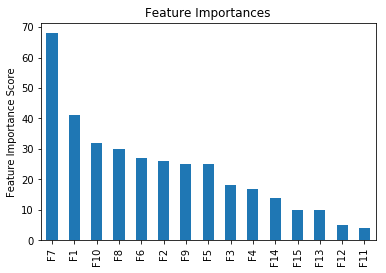

In [167]:
df_train_final_v3_mlens = pd.DataFrame(train_final_v3_mlens, columns=["F{}".format(x) for x in range(1, len(base_learners_v3_final_mlens) + 1)])
model_fit(XGBClassifier(**xgb_mlens_params), df_train_final_v3_mlens, df_train_final_v3_mlens.columns.values)

In [216]:
xgb_mlens_v3 = XGBClassifier(**xgb_mlens_params)

xgb_v3_n_est = {
    "n_estimators": range(30, 60)
}

gs_xgb_v3_n_est = GridSearchCV(estimator=xgb_mlens_v3, param_grid=xgb_v3_n_est, cv=n_splits, scoring="roc_auc", n_jobs=-1, verbose=1)
gs_xgb_v3_n_est.fit(train_final_v3_mlens, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   35.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.68, gamma=0, learning_rate=0.09,
       max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
       n_estimators=46, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.685),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [107]:
# With all KNN base ests
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 51}
0.773236996023751


In [173]:
# With n_neighbors = 16, 32, 64, 128, 256
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 49}
0.7770819737125232


In [196]:
# With n_neighbors = 16, 32, 64, 128, 256 (after 1st iteration of tuning)
print gs_xgb_v3_n_est.best_params_
print gs_xgb_v3_n_est.best_score_

{'n_estimators': 46}
0.7780699505546435


In [207]:
xgb_v3_md_mcw = {
    "max_depth": range(3, 6),
    "min_child_weight": range(4, 9)
}

gs_xgb_v3_md_mcw = GridSearchCV(estimator=XGBClassifier(**xgb_mlens_params), 
                                                       param_grid=xgb_v3_md_mcw, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_md_mcw.fit(train_final_v3_mlens, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   24.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.68, gamma=0, learning_rate=0.09,
       max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
       n_estimators=46, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.685),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5], 'min_child_weight': [4, 5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [176]:
print gs_xgb_v3_md_mcw.best_params_
print gs_xgb_v3_md_mcw.best_score_

{'max_depth': 4, 'min_child_weight': 4}
0.7773744691782225


In [209]:
# With n_neighbors = 16, 32, 64, 128, 256 (after 1st iteration of tuning)
print gs_xgb_v3_md_mcw.best_params_
print gs_xgb_v3_md_mcw.best_score_

{'max_depth': 3, 'min_child_weight': 7}
0.7781278817683718


In [210]:
xgb_v3_gamma = {
    "gamma": [0, 0.001, 0.002, 0.003, 0.004, 0.005]
}

gs_xgb_v3_gamma = GridSearchCV(estimator=XGBClassifier(**xgb_mlens_params), 
                                                       param_grid=xgb_v3_gamma, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_gamma.fit(train_final_v3_mlens, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.68, gamma=0, learning_rate=0.09,
       max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
       n_estimators=46, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.685),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': [0, 0.001, 0.002, 0.003, 0.004, 0.005]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [183]:
print gs_xgb_v3_gamma.best_params_
print gs_xgb_v3_gamma.best_score_

{'gamma': 0}
0.7770819737125232


In [211]:
# With n_neighbors = 16, 32, 64, 128, 256 (after 1st iteration of tuning)
print gs_xgb_v3_gamma.best_params_
print gs_xgb_v3_gamma.best_score_

{'gamma': 0}
0.7781278817683718


In [212]:
xgb_v3_ss_cb = {
    "subsample": [0.68, 0.685, 0.69, 0.695, 0.7, 0.705, 0.71, 0.715, 0.72],
    "colsample_bytree": [0.68, 0.685, 0.69, 0.695, 0.7, 0.705, 0.71, 0.715, 0.72]
}

gs_xgb_v3_ss_cb = GridSearchCV(estimator=XGBClassifier(**xgb_mlens_params), 
                                                       param_grid=xgb_v3_ss_cb, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_ss_cb.fit(train_final_v3_mlens, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.68, gamma=0, learning_rate=0.09,
       max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
       n_estimators=46, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.685),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.68, 0.685, 0.69, 0.695, 0.7, 0.705, 0.71, 0.715, 0.72], 'colsample_bytree': [0.68, 0.685, 0.69, 0.695, 0.7, 0.705, 0.71, 0.715, 0.72]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [185]:
print gs_xgb_v3_ss_cb.best_params_
print gs_xgb_v3_ss_cb.best_score_

{'subsample': 0.685, 'colsample_bytree': 0.68}
0.7776488976761237


In [213]:
# With n_neighbors = 16, 32, 64, 128, 256 (after 1st iteration of tuning)
print gs_xgb_v3_ss_cb.best_params_
print gs_xgb_v3_ss_cb.best_score_

{'subsample': 0.685, 'colsample_bytree': 0.68}
0.7781278817683718


In [214]:
xgb_v3_learning_rate = {
    "learning_rate": [0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12]
}

gs_xgb_v3_learning_rate = GridSearchCV(estimator=XGBClassifier(**xgb_mlens_params), 
                                                       param_grid=xgb_v3_learning_rate, 
                                                       cv=n_splits, 
                                                       scoring="roc_auc", 
                                                       n_jobs=-1, 
                                                       verbose=1)
gs_xgb_v3_learning_rate.fit(train_final_v3_mlens, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    9.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.68, gamma=0, learning_rate=0.09,
       max_delta_step=0, max_depth=3, min_child_weight=7, missing=None,
       n_estimators=46, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.685),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [190]:
print gs_xgb_v3_learning_rate.best_params_
print gs_xgb_v3_learning_rate.best_score_

{'learning_rate': 0.09}
0.7777948582010761


In [215]:
# With n_neighbors = 16, 32, 64, 128, 256 (after 1st iteration of tuning)
print gs_xgb_v3_learning_rate.best_params_
print gs_xgb_v3_learning_rate.best_score_

{'learning_rate': 0.09}
0.7781278817683718


In [338]:
rf_meta_mlens_v3 = RandomForestClassifier(n_jobs=-1, n_estimators=300, max_depth=8, max_features=2)
xgb_meta_mlens_v3 = XGBClassifier(**xgb_mlens_params)

mlens_base_learners_v3 = [
    RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=1000, n_jobs=-1),
    LogisticRegression(C=100, tol=1e-05, solver="liblinear"),
    ExtraTreesClassifier(max_depth=12, n_estimators=250, n_jobs=-1, criterion="entropy"),
    AdaBoostClassifier(n_estimators=395, learning_rate=1.55),
    XGBClassifier(learning_rate=0.1,
                    n_estimators=345,
                    max_depth=8,
                    min_child_weight=2,
                    gamma=0.2,
                    subsample=0.6,
                    colsample_bytree=0.5,
                    objective="binary:logistic",
                    n_jobs=-1,
                    scale_pos_weight=1,
                    seed=seed),
    BaggingClassifier(base_estimator=XGBClassifier(learning_rate=0.1,
                                                    n_estimators=345,
                                                    max_depth=8,
                                                    min_child_weight=2,
                                                    gamma=0.2,
                                                    subsample=0.6,
                                                    colsample_bytree=0.5,
                                                    objective="binary:logistic",
                                                    n_jobs=-1,
                                                    scale_pos_weight=1,
                                                    seed=seed), 
                      n_estimators=50, max_samples=0.7, max_features=0.75, bootstrap_features=True)
]

ensemble_v3 = SuperLearner(random_state=seed, scorer=roc_auc_score)
ensemble_v3.add(mlens_base_learners_v3, proba=True)
# ensemble_v3.add_meta(rf_meta_mlens_v3, proba=True)
ensemble_v3.add_meta(xgb_meta_mlens_v3, proba=True)
mlens_v3_preds_knn = ensemble_v3.fit(meta_features_train_v3, y_train).predict_proba(meta_features_test_v3)[:,1]

In [150]:
print mlens_v3_preds_knn
save_preds(mlens_v3_preds_knn, "mlens_v3_with_knn")

[0.9761619  0.70373476 0.9570611  ... 0.93645567 0.98507524 0.9569393 ]


In [220]:
print mlens_v3_preds_knn
save_preds(mlens_v3_preds_knn, "mlens_v3_with_knn_16_32_64_128_256")

[0.9754563  0.68639696 0.949029   ... 0.92335254 0.9772997  0.9586274 ]


In [339]:
base_learners_v3 = [
    "random_forest_raw",
    "xgboost_reduced",
    "xgboost_raw",
    "xgboost_base",
    "xgboost_poly",
    "xgboost_bag",
    "logistic_regression_log",
    "adaboost_base",
    "extra_trees_base"
]

print mlens_v3_preds_knn
save_preds(mlens_v3_preds_knn, "mlens_{}".format("_".join(base_learners_v3)))

[0.9707168  0.7537478  0.9387455  ... 0.9111801  0.97642946 0.95039713]
